In [24]:
import pandas as pd
from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [25]:
def evaluate_lbl2vec_on_dataset(dataset_name: str, n_words: int = 1):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    keywords_cached_df = pd.read_csv(f'cache/{dataset_name}_spacy_keywords.csv')
    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    labels_df['class_result_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )
    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Model
    lbl2vec_model = Lbl2Vec(
        keywords_list=[item for item in labels_df['class_result_keywords']], 
        tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
        label_names=[item for item in labels_df['class_keywords']], 
        min_count=2,
        verbose=False
    )
    lbl2vec_model.fit()

    train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
    test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

    evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
    evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

    y_true_train = evaluation_train['class_keywords']
    y_pred_train = evaluation_train['most_similar_label']

    y_true_test = evaluation_test['class_keywords']
    y_pred_test = evaluation_test['most_similar_label']

    current_f1_score_train = f1_score(y_true_train, y_pred_train, average='micro')
    current_f1_score_test = f1_score(y_true_test, y_pred_test, average='micro')

    return current_f1_score_train, current_f1_score_test

In [26]:
iterations_results_df = pd.DataFrame()

f1_scores_train = []
f1_scores_test = []

for n_iterations in range(100):
    print(f'[INFO] Iteration {n_iterations + 1}' + ' ' * 50, end='\r')

    current_f1_score_train, current_f1_score_test = evaluate_lbl2vec_on_dataset('BBC_News', n_words=5)
    
    f1_scores_train.append(current_f1_score_train)
    f1_scores_test.append(current_f1_score_test)

    iterations_results_df = pd.concat([
        iterations_results_df, 
        pd.DataFrame({
            'n_iterations': n_iterations + 1,
            'mean_train': sum(f1_scores_train) / len(f1_scores_train),
            'mean_test': sum(f1_scores_test) / len(f1_scores_test),
            'var_train': sum([(f1_score - (sum(f1_scores_train) / len(f1_scores_train)))**2 for f1_score in f1_scores_train]) / len(f1_scores_train),
            'var_test': sum([(f1_score - (sum(f1_scores_test) / len(f1_scores_test)))**2 for f1_score in f1_scores_test]) / len(f1_scores_test)
        }, index=[0])
    ])

iterations_results_df.head()

,n_iterations,mean_train,mean_test,var_train,var_test
0,1,0.756742,0.752809,0.000000,0.000000
0,2,0.779775,0.762921,0.000531,0.000102
0,3,0.759925,0.740824,0.001142,0.001045
0,4,0.746208,0.725843,0.001421,0.001457
0,5,0.738090,0.718202,0.001400,0.001399


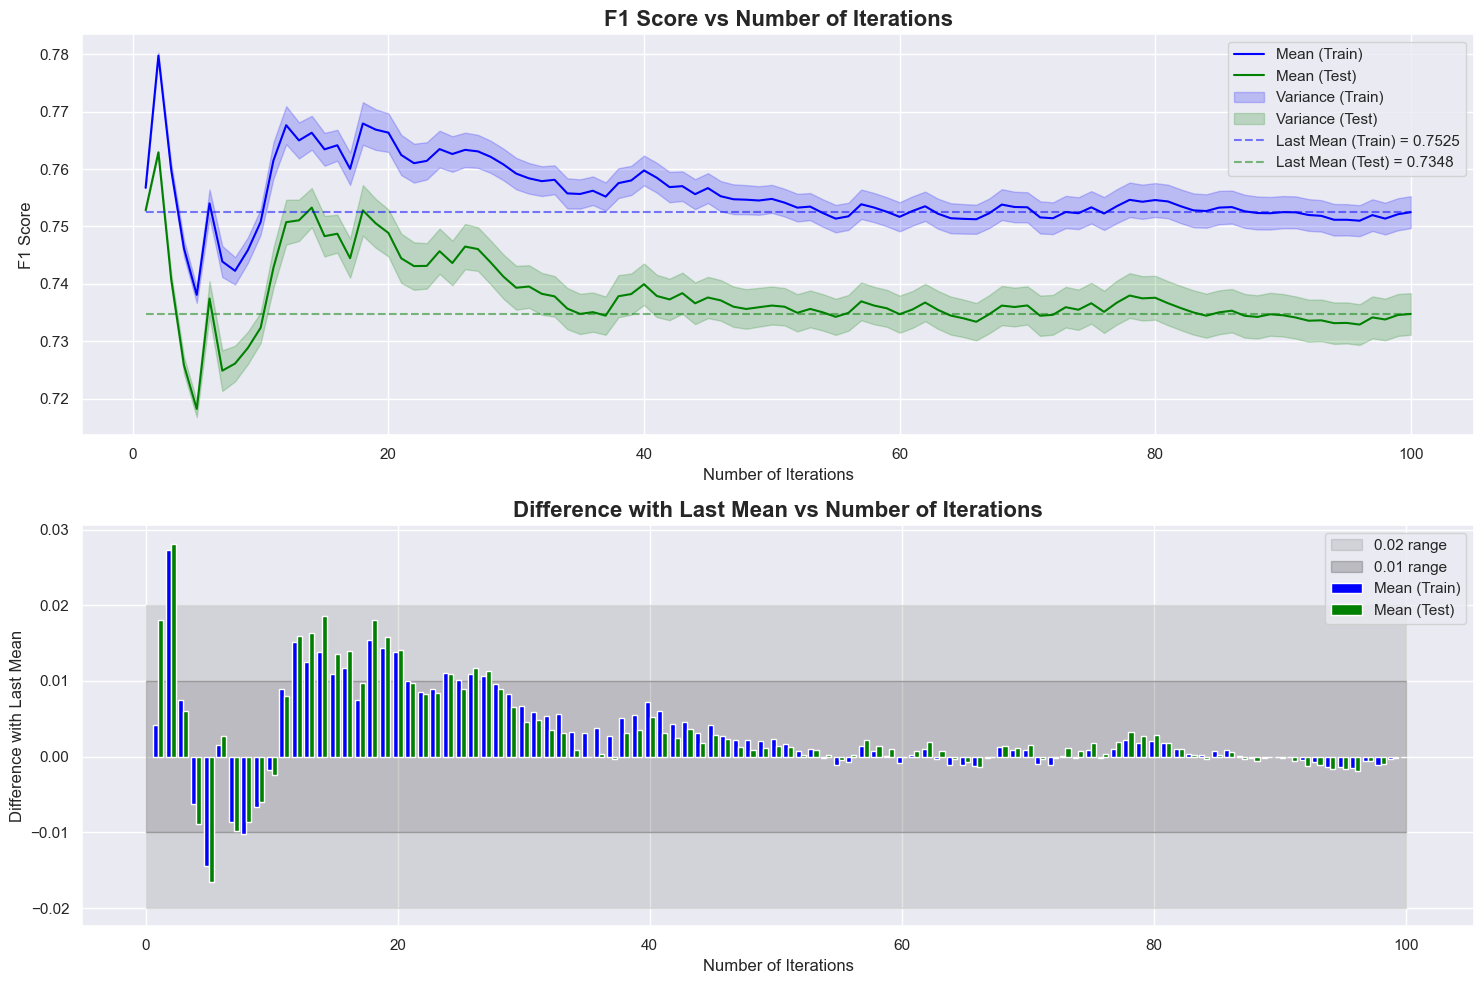

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

n_iter_x = iterations_results_df['n_iterations']

# -- Iteration plot lines
axs[0].plot(n_iter_x, iterations_results_df['mean_train'], label='Mean (Train)', color='blue')
axs[0].plot(n_iter_x, iterations_results_df['mean_test'], label='Mean (Test)', color='green')

axs[0].fill_between(n_iter_x, iterations_results_df['mean_train'] - iterations_results_df['var_train'], iterations_results_df['mean_train'] + iterations_results_df['var_train'], alpha=0.2, color='blue', label='Variance (Train)')
axs[0].fill_between(n_iter_x, iterations_results_df['mean_test'] - iterations_results_df['var_test'], iterations_results_df['mean_test'] + iterations_results_df['var_test'], alpha=0.2, color='green', label='Variance (Test)')

last_mean_train = iterations_results_df['mean_train'].iloc[-1]
last_mean_test = iterations_results_df['mean_test'].iloc[-1]

axs[0].plot(n_iter_x, [last_mean_train] * len(n_iter_x), linestyle='--', color='blue', label=f'Last Mean (Train) = {last_mean_train:.4f}', alpha=0.5)
axs[0].plot(n_iter_x, [last_mean_test] * len(n_iter_x), linestyle='--', color='green', label=f'Last Mean (Test) = {last_mean_test:.4f}', alpha=0.5)

axs[0].set_title('F1 Score vs Number of Iterations', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Number of Iterations')
axs[0].set_ylabel('F1 Score')
axs[0].legend()

# -- Difference with last mean bar plot
axs[1].fill_between([0] + list(n_iter_x), [0.02] * (len(n_iter_x) + 1), [0.01] * (len(n_iter_x) + 1), alpha=0.1, color='black', label='0.02 range')
axs[1].fill_between([0] + list(n_iter_x), [-0.02] * (len(n_iter_x) + 1), [-0.01] * (len(n_iter_x) + 1), alpha=0.1, color='black')
axs[1].fill_between([0] + list(n_iter_x), [0.01] * (len(n_iter_x) + 1), [-0.01] * (len(n_iter_x) + 1), alpha=0.2, color='black', label='0.01 range')

axs[1].bar(n_iter_x - 0.2, iterations_results_df['mean_train'] - last_mean_train, label='Mean (Train)', color='blue', width=0.4)
axs[1].bar(n_iter_x + 0.2, iterations_results_df['mean_test'] - last_mean_test, label='Mean (Test)', color='green', width=0.4)

axs[1].set_title('Difference with Last Mean vs Number of Iterations', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Number of Iterations')
axs[1].set_ylabel('Difference with Last Mean')
axs[1].legend()

fig.tight_layout()
fig.savefig('../figures/f1_score_vs_number_iterations.png')